In [22]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from seaborn import boxplot
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

# added
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam


In [26]:
#%pip install xgboost
#%pip install keras-tuner --upgrade

In [28]:
data=pd.read_csv('Data/Iowa1.csv')
data.head()

,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),Soil type,...,Sand Content %,Clay Content %,Silt Content %,soil bulk density (grams per cubic centimeter),wilting point %,field capacity %,saturation point (cm),Yield (27.6gN/m2),Yield (11.6gN/m2),Yield (40.1gN/m2)
0,1982,1,32486.40039,4,185.600006,24,-7.5,-22.0,120,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
1,1982,2,32486.40039,9,176.000000,32,-1.0,-14.0,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
2,1982,3,32486.40039,10,169.600006,40,-2.0,-14.0,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
3,1982,4,32486.40039,9,124.800003,52,-7.0,-14.5,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
4,1982,5,32486.40039,0,252.800003,52,-2.0,-16.5,160,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0


In [30]:
#Data drop for US data
data = data.drop('year',axis=1)
data = data.drop('Soil type',axis=1)
data = data.drop('swe (kg/m^2)',axis=1)
data = data.drop('Soil pH',axis=1)
data = data.drop('Yield (40.1gN/m2)',axis=1)
data = data.drop('Yield (11.6gN/m2)',axis=1)
data = data.drop(' soil bulk density (grams per cubic centimeter)',axis=1)
data = data.drop(' wilting point %',axis=1)
data = data.drop('field capacity %',axis=1)
data = data.drop('saturation point (cm)',axis=1)
data = data.drop('Soil Organic matter %',axis=1)
data = data.drop('Sand Content %',axis=1)
data = data.drop('Clay Content %',axis=1)
data = data.drop('Silt Content %',axis=1)


data.head()

,yday,dayl (s),prcp (mm/day),srad (W/m^2),tmax (deg c),tmin (deg c),vp (Pa),Yield (27.6gN/m2)
0,1,32486.40039,4,185.600006,-7.5,-22.0,120,0.0
1,2,32486.40039,9,176.000000,-1.0,-14.0,200,0.0
2,3,32486.40039,10,169.600006,-2.0,-14.0,200,0.0
3,4,32486.40039,9,124.800003,-7.0,-14.5,200,0.0
4,5,32486.40039,0,252.800003,-2.0,-16.5,160,0.0


In [32]:
x_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_data = data.values[:, :-1]
y_data = data.values[:, -1].reshape((-1, 1))
x_scaler.fit(x_data)
y_scaler.fit(y_data)
x_r_data = x_scaler.transform(x_data)
y_r_data = y_scaler.transform(y_data)

In [34]:
X_, y = x_r_data[:], y_r_data.reshape((1, -1))[0]

In [36]:
pca_model = PCA(n_components=3)
X = pca_model.fit_transform(X_)

In [48]:
# added
lstm_model = Sequential()
lstm_model.add(Input(shape=(X.shape[1], 3)))
lstm_model.add(LSTM(units=400, return_sequences=True))#, kernel_regularizer=L1L2(l1=0.001, l2=0.001)
lstm_model.add(LSTM(units=496))#, kernel_regularizer=L1L2(l1=0.001, l2=0.001)
lstm_model.add(Dense(1))

lstm_model.compile(loss='mse', optimizer=Adam(learning_rate=0.009000000000000001))

# Implement early stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 

lstm_model.fit(X.reshape(-1, 1, X.shape[1]), y, epochs=100, batch_size=30, validation_split=0.2, verbose=0)

lstm_predictions = lstm_model.predict(X.reshape(-1, 1, X.shape[1]))

inv_lstm_preds = y_scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).reshape((1, -1))[0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [50]:
mse_ls = mean_squared_error(y, lstm_predictions)
rmse_ls = math.sqrt(mse_ls)
rrmse_ls = rmse_ls/np.mean(y)
mae_ls = mean_absolute_error(y, lstm_predictions)
r2_ls = r2_score(y, lstm_predictions)

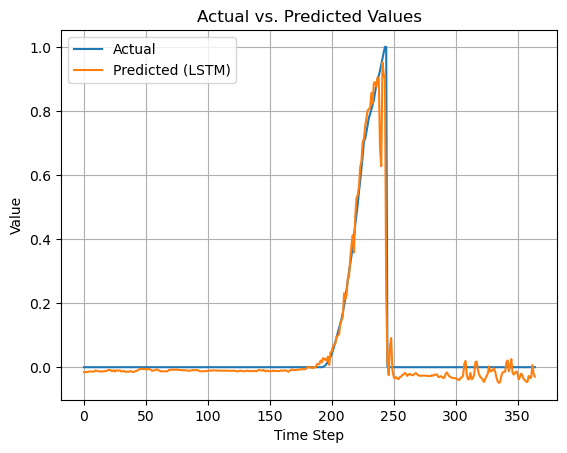

In [52]:
plt.plot(y, label='Actual')
plt.plot(lstm_predictions, label='Predicted (LSTM)')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import HyperModel,  RandomSearch

# Define the hyperparameter search space
def build_lstm_model(hp):
  lstm_model = Sequential()
  lstm_model.add(Input(shape=(X.shape[1], 3)))

  # Hyperparameter: Number of units in the first LSTM layer
  units = hp.Int('units_1', min_value=32, max_value=1024, step=16)
  lstm_model.add(LSTM(units=units, return_sequences=True))

  # Hyperparameter: Number of units in the second LSTM layer
  units = hp.Int('units_2', min_value=32, max_value=1024, step=16)
  lstm_model.add(LSTM(units=units))

  # Hyperparameter: Learning rate for the optimizer
  learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=0.01, step=0.001)
  lstm_model.add(Dense(1))

  lstm_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
  return lstm_model

# Create a HyperModel instance
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10, 
    executions_per_trial=1  
)

# Implement early stopping callback (optional)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start hyperparameter search
tuner.search(X.reshape(-1, 1, X.shape[1]), y, epochs=10, validation_split=0.2, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models()[0]

# Use the best model for prediction
lstm_predictions = best_model.predict(X.reshape(-1, 1, X.shape[1]))
inv_lstm_preds = y_scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).reshape((1, -1))[0]

Trial 10 Complete [00h 00m 05s]
val_loss: 0.005769847892224789

Best val_loss So Far: 0.005769847892224789
Total elapsed time: 00h 00m 52s
 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step

H:\Anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [46]:
best_params = tuner.get_best_hyperparameters()[0].values
print(best_params)

{'units_1': 400, 'units_2': 496, 'learning_rate': 0.009000000000000001}
